第三章的开始以线性回归作为引子，线性回归是常见的一类深度学习可以解决的问题，实质上是在寻找特定线性问题的最小二乘解
在数学上我们可以通过列满秩和QR分解解决最小二乘解问题，但不是所有的实际场景可以寻找到解析解，因此需要神经网络参与

线性回归开始之前写了一个关于计算时间的time类 目的是说明类似ndarray和torch.tensor之类的矢量操作相较于传统的在列表元组中对元素进行操作效率要高很多

In [6]:
import time as Time
import torch
import numpy as np

class Timer:
    def __init__(self):
        self.time = []
        self.start()

    def start(self):
        self.step = Time.time()

    def stop(self):
        self.time.append(Time.time() - self.step)
        return self.time[-1]
    
    def sum(self):
        return sum(self.time)
    
    def mean(self):
        return sum(self.time) / len(self.time)
    
num = 1000000
a = torch.ones(num)
b = torch.ones(num)

c = torch.zeros(num)

timer_1 = Timer()

for i in range(num):   
    c[i] = a[i] + b[i] 

print(f"calculate time is {timer_1.stop():.10f}")

timer_1.start()

c = a + b

print(f"calculate time is {timer_1.stop():.10f}")


    

calculate time is 7.4416744709
calculate time is 0.0010046959


之后d2l又拿了一些篇幅说明了一下如何从极大似然估计的角度来理解最小二乘解的求解，其实就是为什么要设置l_2的损失函数，这部分是比较简单的

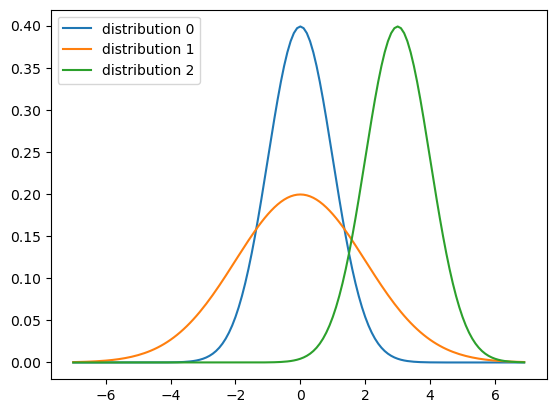

In [10]:
import math
from matplotlib import pyplot as plt

def normal_distribution(x,m,d):
    pre = 1 / np.sqrt(2 * math.pi * d ** 2)
    return pre * np.exp(-(1/2) * (x-m) ** 2 / d ** 2)

example = [[0,1],[0,2],[3,1]]

xspace = np.arange(-7,7,0.1)

fig,axe = plt.subplots()
for i in range(3):
    axe.plot(xspace,normal_distribution(xspace,example[i][0],example[i][1]),label = f"distribution {i}")
axe.legend()


接下来会开始从零实现线性回归的神经网络，总的步骤包括设置数据集，读取数据集，初始化模型参数，定义模型结构，定义损失函数，定义优化算法，在做完一切的准备工作之后，就可以直接训练得到结果了

我们在正式进入神经网络的编写前先了解一些预备知识：
在我们的后面内容中，我们会涉及到神经网络在特定的上下文环境中运行，以及以什么样的模式来运行网络，常见的例子就是with torch.no_grad():和model.train()、model.eval()
with torch.no_grad()常用于参数更新和推理阶段，它的作用是关闭梯度跟踪，在with torch.no_grad()上下文管理器下，PyTorch不会记录张量操作的计算图，也不会自动计算梯度，这样也能节省内存和计算资源，避免因保留不必要的中间变量而导致的内存占用：因此在参数更新的场景下，参数更新只是单纯的数值操作，我们并不想把他加入到计算图中；推理类似，我们只需要用，并不再需要进行复杂的计算和生成计算图，但这个场景下可以使用更加精确的：with torch.inference_mode():，因为这个上下文中还可以禁用一些内部机制
model.eval()通常会和with.torch.no_grad():一起使用，这说明现在的网络处于评估模式，model.eval()通常发生在normalization和dropout中，为什么会有评估模式的出现呢：可以想象这两个方法的应用场景，比如batch normalization在训练的时候是根据单个batch中的数据来计算均值方差的，但在测试时只能去计算训练时总的均值和方差来等效替代测试数据中的这两项，再比如dropout中，训练时会随机地舍弃部分结点，但推理的时候就直接使用了所有的网络结点，也就是说，实际上测试模式和model.train()的出现会为了切换模型的行为，他解决的是逻辑问题，但with torch.no_grad()解决的是当前的操作是否要加入计算图，是否占用计算资源，解决的是资源问题，与with torch.no_grad():对应的是with torch.enable_grad():
因此这两者还是有本质的差别，甚至在model.eval()中也可以with torch.enable_grad():

推理时建议使用with torch.inference_mode():
